# IMAGE COLORIZATION USING cGAN

**Contents**

1. [Import Packages](#packages)
2. [Utils](#utils)
3. [Data preparation](#dataset)
4. [Image Colorization and Color Science Computation](#4-image-colorization-and-color-science-computations)
5. [Generator architecture](#generator)
6. [Discriminator architecture](#discriminator)
7. [Trainer](#training)
8. [Validation](#validation)

## 1. Import Packages <a class="anchor" id="packages"></a>

In [1]:
# Operating system and file operations
import os

# Numerical operations and array processing
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Random number generation
import random

# Image processing and computer vision
import cv2

# Deep learning and neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F

# Data handling for deep learning
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Displaying model information
from torchsummary import summary

# Image manipulation
from PIL import Image

# Type annotations
from typing import List

# Progress bar for Jupyter Notebooks
from tqdm.notebook import tqdm

# Color space conversions
from colour import sRGB_to_XYZ, XYZ_to_Lab, Lab_to_XYZ, XYZ_to_sRGB

# Image quality assessment
from skimage.metrics import structural_similarity as ssim

# Memory management
import gc

# Evaluation
from evaluation import calculate_ssim
from evaluation import calculate_colourfulness

# Handling warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


E:\Baru\Lib\site-packages\colour\utilities\verbose.py:265: ColourWarning: "vaab/colour" was detected in "sys.path", please define a "COLOUR_SCIENCE__COLOUR__IMPORT_VAAB_COLOUR=True" environment variable to import its objects into "colour" namespace!
  warn(*args, **kwargs)  # noqa: B028


## 2. Utils <a class="anchor" id="utils"></a>

In [2]:
# # Determine the device to use for PyTorch operations
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Print the selected device which device will be used for PyTorch operations.
# print(device)

=======================================================================

## 3. Data Preparation

=======================================================================

## 4. Image Colorization and Color Science Computations

In [3]:
def lab_to_rgb(L, ab, device):
    """
    Takes a batch of images
    """
    L = 100 * L  # Scale the L component from 0-1 to 0-100
    ab = (ab - 0.5) * 256  # Adjust the a and b components to the correct range
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy()  # Combine L, a, b, and rearrange the format for processing
    rgb_imgs = []  # Initialize a list to store the resulting RGB images
    for img in Lab:
        img = Lab_to_XYZ(img)  # Convert LAB to XYZ
        img = XYZ_to_sRGB(img)  # Convert XYZ to RGB
        rgb_imgs.append(img)  # Append the RGB image to the list
    return torch.tensor(np.stack(rgb_imgs, axis=0)).permute(0, 3, 1, 2).to(device)  # Return the images as a PyTorch tensor and move to the specified device

In [4]:
# Set the desired image size
image_size = (256, 128)

# Compose a series of transformations to be applied to the images
t = transforms.Compose([
    transforms.Resize(image_size, antialias=True),  # Resize the image with antialias to reduce distortion
    transforms.Normalize(mean=0, std=0.5)           # Normalize the images to facilitate neural network processing
])

In [5]:
class ImageColorizeDataset(Dataset):
    def __init__(self, path: str, device='cpu', train: bool = False, transforms = None):
        # Set the dataset mode based on the train argument, 'train' for training and 'test' for testing
        _mode = 'train' if train else 'test'
        
        self.device = device  # Device where data will be processed (CPU or GPU)
        self._input_path = os.path.join(path, f'{_mode}_color')  # Path to the data
        
        self.data = os.listdir(self._input_path)  # List all image files in the directory
        
        self.transforms = transforms  # Transformations to be applied to the images

    def __len__(self):
        return len(self.data)  # Return the number of data in the dataset

    def __getitem__(self, idx: int):
        to_tensor = transforms.ToTensor()  # Transform the image to a tensor
        
        item = self.data[idx]  # Retrieve the data item by index
        
        input_ = Image.open(os.path.join(self._input_path, item))  # Open image
        w, h = input_.size  # Get image dimensions
        left = 0
        top = 0
        right = w
        bottom = h / 2  # Take the top half of the image
        input_ = input_.crop((left, top, right, bottom))  # Crop the image
        
        input_ = to_tensor(input_)  # Convert the cropped image to a tensor
        
        # Set seed for reproducibility
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        if self.transforms is not None:
            input_ = self.transforms(input_)  # Apply transformations if any
        
        img = input_.permute(1, 2, 0).numpy()  # Rearrange axes for color space conversion
        img = sRGB_to_XYZ(img)  # Convert sRGB to XYZ
        img = XYZ_to_Lab(img).transpose(2, 0, 1).astype("float32")  # Convert XYZ to LAB
        
        L = torch.tensor(img[[0], ...] / 100)  # Normalize the L component
        ab = torch.tensor(img[[1, 2], ...] / 256 + 0.5)  # Normalize the a and b components
        
        return L.to(device), ab.to(device)  # Return as tensor and send to the specified device

In [6]:
# Initialize the dataset for testing with specified transformations and not in training mode
test_data = ImageColorizeDataset("dataset_harungguan", 
								 transforms=t, train=False)
# DataLoader for the test dataset, with a batch size of 8 and shuffling enabled
test_dl = DataLoader(test_data, batch_size=4, shuffle=True)

In [7]:
# Initialize the dataset for training with specified transformations and in training mode
train_data = ImageColorizeDataset("dataset_harungguan", 
								  transforms=t, train=True)
# DataLoader for the training dataset, with a batch size of 8 and shuffling enabled
train_dl = DataLoader(train_data, batch_size=4, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


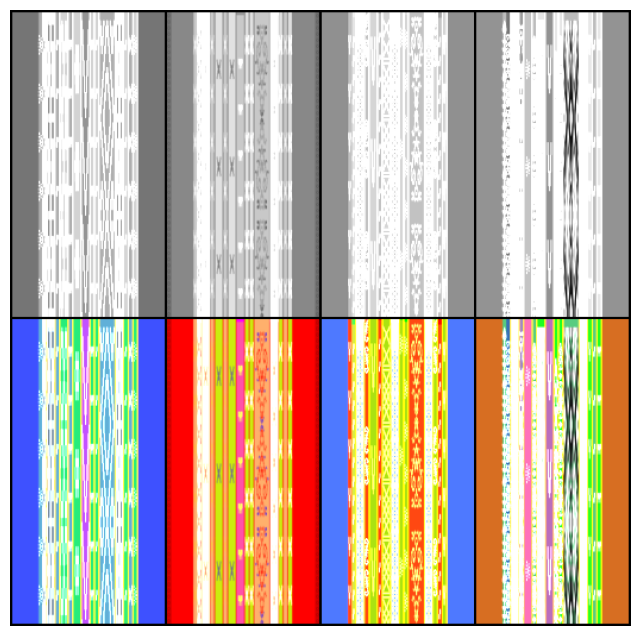

In [8]:
# Retrieve the next batch of images and targets from the training DataLoader
images, targets = next(iter(train_dl))

# Convert LAB images back to RGB using the lab_to_rgb function for visualization
to_show = lab_to_rgb(images, targets, device=device)

# Create a grid of images combining the original and colorized images for display
grid = torchvision.utils.make_grid(
    torch.cat([images.expand(to_show.shape), to_show], dim=0),  # Concatenate original and colorized images
    nrow=4,          # Number of images per row
    # padding=4,       # Space between images
    scale_each=True, # Scale images individually
    # border=2         # Border size around images
)

# Plot the grid of images using matplotlib
fig = plt.figure(figsize=(16,8))  # Set the figure size
plt.imshow(grid.cpu().permute(1,2,0))  # Convert tensor to numpy array and display as image
plt.axis('off')  # Hide axes
plt.show()  # Display the plot

In [9]:
# print(a.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(close=None, block=None)>

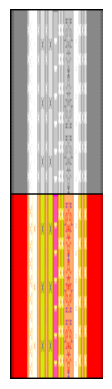

In [10]:
a = grid.cpu().permute(1,2,0)
plt.imshow((torch.split(a,130, dim=1)[1]))
plt.axis('off')
plt.show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(close=None, block=None)>

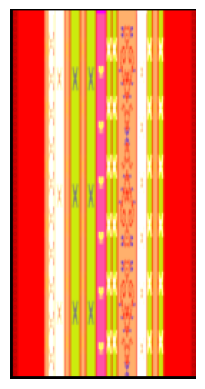

In [11]:
a = grid.cpu().permute(1,2,0)
half_index = a.size(0) // 2
second_portion = a[half_index:, :, :]
plt.imshow((torch.split(second_portion,130, dim=1)[1]))
plt.axis('off')
plt.show

## 5. Generator <a class="anchor" id="generator"></a>

UNet model was used as a generator. It takes image as an input. To randomize output of generator, dropout layers applied both at training and evalutaion time as a noise.

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, norm_layer=nn.BatchNorm2d):
        super().__init__()
        # Defines a sequential container for two convolutional blocks with BatchNorm and ReLU activation
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            norm_layer(out_channels),  # Normalization layer, here using BatchNorm
            nn.ReLU(inplace=True),     # ReLU activation with in-place operation to save memory
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            norm_layer(out_channels),  # Second normalization layer
            nn.ReLU(inplace=True)      # Second ReLU activation
        )
        
        # Identity mapping that may be used to match dimensions for the residual connection
        self.identity = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.relu = nn.ReLU(inplace=True)  # Final ReLU activation after adding the residual
        
    def forward(self, x):
        x_ = x.detach().clone()  # Detach and clone the input to prevent modifications during forwarding
        x_ = self.block(x_)       # Pass the input through the convolutional block
        
        residual = self.identity(x)  # Apply the identity mapping to the original input
        
        out = x_ + residual          # Add the output of the convolutional block to the identity mapping
        
        return self.relu(out)        # Apply a ReLU activation to the combined output and return it

In [13]:
class EncoderBlock(nn.Module):
    def __init__(self, in_chans, out_chans, sampling_factor=2):
        super().__init__()
        # Sequential container for an encoder block that includes a max pooling followed by a convolutional block
        self.block = nn.Sequential(
            nn.MaxPool2d(sampling_factor),  # Reduces the spatial dimensions of the input
            ConvBlock(in_chans, out_chans) # Applies a convolutional block to further process the data
        )
        
    def forward(self, x):
        # Forward pass of the encoder block: applies pooling and then convolution
        return self.block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_chans, out_chans, sampling_factor=2):
        super().__init__()
        # Upsampling layer to increase the spatial dimensions of the input
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        
        # Convolutional block that processes the concatenated input from the upsampled feature map and the skip connection
        self.block = ConvBlock(in_chans + out_chans, out_chans)
        
    def forward(self, x, skip):
        # Upsamples the input feature map
        x = self.upsample(x)
        # Concatenates the upsampled feature map with the skip connection feature map
        x = torch.cat([x, skip], dim=1)
        # Processes the concatenated feature maps using a convolutional block
        x = self.block(x)
        return x

In [14]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, dropout_rate=0.1):
        super().__init__()
        # Initialize the encoder part of the U-Net with progressively increasing channels
        self.encoder = nn.ModuleList([
            ConvBlock(in_channels, 64),
            EncoderBlock(64, 128),
            EncoderBlock(128, 256),
            EncoderBlock(256, 512),
        ])
        # Initialize the decoder part of the U-Net with progressively decreasing channels
        self.decoder = nn.ModuleList([
            DecoderBlock(512, 256),
            DecoderBlock(256, 128),
            DecoderBlock(128, 64)
        ])
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout2d(dropout_rate)
        # Final convolution layer to map the decoded features to the desired number of output channels
        self.logits = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)
    
    def forward(self, x):
        encoded = []
        # Pass input through each encoder block, apply dropout, and store intermediate outputs for skip connections
        for enc in self.encoder:
            x = enc(x)
            x = self.dropout(x)
            encoded.append(x)

        enc_out = encoded.pop()
        
        # Start the decoding process using the stored encoded features
        for dec in self.decoder:
            enc_out = encoded.pop()  # Retrieve the corresponding encoder output for skip connections
            x = dec(x, enc_out)  # Decoder block processes input with skip connections
        # Apply a sigmoid activation to the final layer's output to normalize the output to [0,1] range
        return F.sigmoid(self.logits(x))

In [15]:
# Trigger the garbage collector to free memory from unreferenced objects.
gc.collect()

3642

## 4. Discriminator <a class="anchor" id="discriminator"></a>

Due to our input image shape `batch_size x 3 x 256 x 128`, in out PatchGAN discriminator we have 3 sequential `3 x 3` conv

In [16]:
class PatchGAN(nn.Module):
    def __init__(self, in_channels, n_features=64, n_layers=3):
        super().__init__()
        # Initialize the PatchGAN architecture parameters
        k_size = 4  # kernel size
        p_size = 2  # padding size
        
        # Starting layer configuration with a convolutional layer and a LeakyReLU activation
        seq = [
            nn.Conv2d(in_channels=in_channels, out_channels=n_features, kernel_size=k_size, padding=p_size, stride=2),
            nn.LeakyReLU(0.2, True)
        ]
        
        # Factor multipliers for feature map scaling in subsequent layers
        f_mult = 1
        f_mult_prev = 1
        
        # Construct additional convolutional layers as specified by n_layers
        for i in range(1, n_layers):
            f_mult_prev = f_mult
            f_mult = min(2 ** i, 8)  # Update feature multiplier with constraints
            
            seq.append(nn.Conv2d(in_channels=f_mult_prev * n_features, out_channels=f_mult * n_features, kernel_size=k_size, padding=p_size, stride=2))
            seq.append(nn.BatchNorm2d(f_mult * n_features))  # Batch normalization for stability
            seq.append(nn.LeakyReLU(0.2, True))  # LeakyReLU for non-linear processing

        # Last convolutional layers before the final output layer
        f_mult_prev = f_mult
        f_mult = min(2 ** n_layers, 8)
        
        seq += [
            nn.Conv2d(n_features * f_mult_prev, n_features * f_mult, kernel_size=k_size, stride=1, padding=p_size),
            nn.BatchNorm2d(n_features * f_mult),
            nn.LeakyReLU(0.2, True)
        ]

        # Final convolutional layer to produce a 1-channel prediction map
        seq += [nn.Conv2d(n_features * f_mult, 1, kernel_size=k_size, stride=1, padding=p_size)]
        self.model = nn.Sequential(*seq)

    def forward(self, x, label):
        # Concatenate input and label along the channel dimension for conditional GAN processing
        x = torch.cat((x, label), dim=1)
        x = self.model(x)  # Pass through the network
        return x

In [17]:
D = PatchGAN(in_channels=3).to(device)  # Initialize the PatchGAN discriminator

# Display the model architecture
summary(D, [(1, image_size[0], image_size[1]), (2, image_size[0], image_size[1])])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 129, 65]           3,136
         LeakyReLU-2          [-1, 64, 129, 65]               0
            Conv2d-3          [-1, 128, 65, 33]         131,200
       BatchNorm2d-4          [-1, 128, 65, 33]             256
         LeakyReLU-5          [-1, 128, 65, 33]               0
            Conv2d-6          [-1, 256, 33, 17]         524,544
       BatchNorm2d-7          [-1, 256, 33, 17]             512
         LeakyReLU-8          [-1, 256, 33, 17]               0
            Conv2d-9          [-1, 512, 34, 18]       2,097,664
      BatchNorm2d-10          [-1, 512, 34, 18]           1,024
        LeakyReLU-11          [-1, 512, 34, 18]               0
           Conv2d-12            [-1, 1, 35, 19]           8,193
Total params: 2,766,529
Trainable params: 2,766,529
Non-trainable params: 0
---------------------------

E:\Baru\Lib\site-packages\torchsummary\torchsummary.py:100: RuntimeWarning: overflow encountered in scalar multiply
  total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))


In [18]:
G = UNet(in_channels=1, out_channels=2).to(device)
# G2 = UNet(in_channels=2, out_channels=1).to(device)

# summary(G, (1, 384, 384))
summary(G, (1, image_size[0], image_size[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 128]             576
       BatchNorm2d-2         [-1, 64, 256, 128]             128
              ReLU-3         [-1, 64, 256, 128]               0
            Conv2d-4         [-1, 64, 256, 128]          36,864
       BatchNorm2d-5         [-1, 64, 256, 128]             128
              ReLU-6         [-1, 64, 256, 128]               0
            Conv2d-7         [-1, 64, 256, 128]             576
              ReLU-8         [-1, 64, 256, 128]               0
         ConvBlock-9         [-1, 64, 256, 128]               0
        Dropout2d-10         [-1, 64, 256, 128]               0
        MaxPool2d-11          [-1, 64, 128, 64]               0
           Conv2d-12         [-1, 128, 128, 64]          73,728
      BatchNorm2d-13         [-1, 128, 128, 64]             256
             ReLU-14         [-1, 128, 

## 5. Trainer <a class="anchor" id="training"></a>

In [19]:
# class Trainer: 
#     def __init__(self, G, D, device, batch_size=32, lr_g=1e-4, lr_d=4e-4, l1_lambda=100, d2g_ratio=2, plot_rate=1):
#         self.G = G
#         self.D = D
        
#         self.L1_G_loss = nn.L1Loss()
#         self.G_loss = nn.BCEWithLogitsLoss()
#         self.D_loss = nn.BCEWithLogitsLoss()
        
#         self.G_optim = torch.optim.AdamW(params=G.parameters(), lr=lr_g, betas=(0.5, 0.999))
#         self.D_optim = torch.optim.AdamW(params=D.parameters(), lr=lr_d, betas=(0.5, 0.999))

#         self.batch_size = batch_size
#         self.l1_lambda = l1_lambda
        
#         self.loss_G_per_epoch = []
#         self.loss_D_per_epoch = []
#         self.loss_D_real_per_epoch = []
#         self.loss_D_fake_per_epoch = []
        
#         self.loss_G_history = []
#         self.loss_D_history = []
#         self.loss_D_real_history = []
#         self.loss_D_fake_history = []

#         self.ssim_history = []
#         self.colourfulness_history = []
        
#         self.d2g_ratio = d2g_ratio
#         self.device = device
        
#         self.plot_rate = plot_rate

    
#     def train(self, dataloader, epochs):
#         for epoch in range(epochs):
#             self.loss_G_history.append([])
#             self.loss_D_history.append([])
#             self.loss_D_real_history.append([])
#             self.loss_D_fake_history.append([])
            
#             print(f'EPOCH: {epoch}')
#             for i, (images, targets) in enumerate(tqdm(dataloader)):
                
#                 self._train_discriminator(images, targets)
                
#                 if (i + 1) % self.d2g_ratio == 0:
#                     self._train_generator(images, targets)
    
#             self.loss_G_per_epoch.append(np.mean(self.loss_G_history[-1]))
#             self.loss_D_per_epoch.append(np.mean(self.loss_D_history[-1]))
#             self.loss_D_real_per_epoch.append(np.mean(self.loss_D_real_history[-1]))
#             self.loss_D_fake_per_epoch.append(np.mean(self.loss_D_fake_history[-1]))
            
#             if (epoch + 1) % self.plot_rate == 0:
#                 self._plot_epoch_stats(epoch)
#                 self._plot_fake_images(images, targets, epoch) # Plot the generated images
#             self._plot_stats()
#             self.save_model(epoch) 

#     def _train_generator(self, inputs, targets):
#         self.G_optim.zero_grad()
        
#         self.G.train()
#         self.D.eval()
        
#         fake_targets = self.G(inputs)
        
#         predictions = self.D(inputs, fake_targets)
#         fake_labels = torch.ones(*predictions.shape, device=self.device)  # Real label for generator
        
#         L1_loss = self.L1_G_loss(fake_targets, targets)
#         BCE_loss = self.G_loss(predictions, fake_labels)
#         loss_g = BCE_loss + self.l1_lambda * L1_loss
#         self.loss_G_history[-1].append(loss_g.item())
#         loss_g.backward()
#         self.G_optim.step()
                
#     def _train_discriminator(self, inputs, real_targets):
#         self.D_optim.zero_grad()
        
#         self.G.eval()
#         self.D.train()
        
#         real_predictions = self.D(inputs, real_targets)
#         real_labels = torch.ones(*real_predictions.shape, device=self.device)

#         real_loss = self.D_loss(real_predictions, real_labels)
        
#         fake_targets = self.G(inputs)
#         fake_predictions = self.D(inputs, fake_targets.detach())
#         fake_labels = torch.zeros(*fake_predictions.shape, device=self.device)

#         fake_loss = self.D_loss(fake_predictions, fake_labels)
        
#         loss_d = (real_loss + fake_loss) / 2
        
#         self.loss_D_history[-1].append(loss_d.item())
#         self.loss_D_real_history[-1].append(real_loss.item())
#         self.loss_D_fake_history[-1].append(fake_loss.item())

#         loss_d.backward()
#         self.D_optim.step()
        
#     def _plot_fake_images(self, images, targets, epoch, nrow=1):
#         """
#         Showing the generator's results
#         """
        
#         self.G.eval()
                
#         fake = self.G(images)

#         to_show = lab_to_rgb(images, fake, device=self.device)
#         to_show_real = lab_to_rgb(images, targets, device=self.device)
#         self.save_fake_images(images, fake, epoch)
        
#         # Calculate SSIM
#         score_ssim = calculate_ssim(images, fake, targets)
#         print(f"SSIM: {score_ssim}")
#         self.ssim_history.append(score_ssim)

#         # Calculate Colourfulness
#         score_colourfulness = calculate_colourfulness(images, fake)
#         print(f"Colourfulness: {score_colourfulness}")
#         self.colourfulness_history.append(score_colourfulness)

#         a = fake[:, 0, :, :].unsqueeze(1).expand(to_show.shape)
#         b = fake[:, 1, :, :].unsqueeze(1).expand(to_show.shape)
#         grid = torchvision.utils.make_grid(torch.cat([images.expand(to_show.shape), a, b, to_show, to_show_real], dim=0), nrow=3, padding=1, scale_each=True)
#         grid_image = grid.cpu().permute(1, 2, 0).numpy()
#         grid_image = (grid_image - grid_image.min()) / (grid_image.max() - grid_image.min())  # Scale to [0, 1]

        
#         fig = plt.figure(figsize=(16,8))
#         # plt.imshow((grid.cpu().permute(1,2,0).numpy() * 255).astype(np.uint8))
#         plt.imshow(grid.cpu().permute(1,2,0).numpy())
#         grid_image = (grid_image - grid_image.min()) / (grid_image.max() - grid_image.min())  # Scale to [0, 1]
#         grid_image = (grid_image * 255).astype(np.uint8)  # Scale to [0, 255]
#         plt.axis('off')
#         plt.show()
    
#     def save_fake_images(self, images, fake, epoch):
#         output_dir = 'output_test'
#         if not os.path.exists(output_dir):
#             os.makedirs(output_dir)

#         to_show = lab_to_rgb(images, fake, device=self.device)
        
#         grid = torchvision.utils.make_grid(torch.cat([to_show.expand(to_show.shape), torch.flip(to_show, [2])], dim=0),
#                                            nrow=3, padding=0, scale_each=True)
        
#          # Save the figure using PIL
#         grid_image = grid.cpu().permute(1, 2, 0).numpy()
#         grid_image = (grid_image - grid_image.min()) / (grid_image.max() - grid_image.min())  # Scale to [0, 1]
#         grid_image = (grid_image * 255).astype(np.uint8)  # Scale to [0, 255]

#         for id, ulos in enumerate(np.array_split(grid_image, 3, axis=1)):
#             # pil_image = Image.fromarray((ulos * 255).astype(np.uint8))
#             pil_image = Image.fromarray(ulos)
#             pil_image.save(f'{output_dir}/generated_harungguan_{epoch}_image_{id}.png')

#     def _plot_stats(self):
#             """
#             Plotting stats of history training
#             """
#             fig, axes = plt.subplots(2, 2, figsize=(10, 4))
#             sns.lineplot(self.loss_D_per_epoch, label="discriminator", ax=axes[0][0])
#             sns.lineplot(self.loss_G_per_epoch, label="generator", ax=axes[0][1])
            
#             sns.lineplot(self.loss_D_real_per_epoch, label="real", ax=axes[1][0])
#             sns.lineplot(self.loss_D_fake_per_epoch, label="fake", ax=axes[1][1])
            
#             plt.tight_layout()
#             plt.show()
    
            
#     def _plot_epoch_stats(self, epoch):
#             """
#             Plotting stats of history training
#             """
#             fig, axes = plt.subplots(2, 2, figsize=(10, 4))
#             sns.lineplot(self.loss_D_history[epoch], label="discriminator", ax=axes[0][0])
#             sns.lineplot(self.loss_G_history[epoch], label="generator", ax=axes[0][1])
            
#             sns.lineplot(self.loss_D_real_history[epoch], label="real", ax=axes[1][0])
#             sns.lineplot(self.loss_D_fake_history[epoch], label="fake", ax=axes[1][1])
            
#             plt.tight_layout()
#             plt.show()
            
#     def _plot_losses(self):
#             """
#             Plot the generator and discriminator losses per epoch.
#             """
#             epochs = range(1, len(self.loss_G_per_epoch) + 1)
    
#             plt.figure(figsize=(8, 5))
#             plt.plot(epochs, self.loss_G_per_epoch, label='Generator loss', color='blue')
#             plt.plot(epochs, self.loss_D_per_epoch, label='Discriminator loss', color='red')
#             plt.title('Loss vs. Epoch')
#             plt.xlabel('Epoch')
#             plt.ylabel('Loss')
#             plt.legend()
#             plt.show()
            
#     def plot_ssim_and_colourfulness(self):
#             """
#             Plot SSIM and Colourfulness over epochs.
#             """
#             epochs = range(1, len(self.ssim_history) + 1)
    
#             plt.figure(figsize=(8, 5))
#             plt.plot(epochs, self.ssim_history, label='SSIM', color='green')
#             plt.plot(epochs, self.colourfulness_history, label='Colourfulness', color='purple')
#             plt.title('SSIM and Colourfulness vs. Epoch')
#             plt.xlabel('Epoch')
#             plt.ylabel('Score')
#             plt.legend()
#             plt.show() 

In [20]:
lr_g = 1e-4
lr_d = 4e-4
epochs = 200
l1_lambda = 100 #Discriminator L1 Loss Hyperparameter as Defined in the Pix2Pix Paper 
epoch = 1
betas = (0.5,0.999) #Optimizer Hyperparameter as Defined in the Pix2Pix Paper
D_loss = []
G_loss = []

In [21]:
def ShowSamples(Model, dl, folder='./', epoch= -1, SAVE = True,suffix=""):
    data = next(iter(dl))
    L, ab = data[0], data[1]
    L=L.to(device)
    ab=ab.to(device)
    #Setting Model to Evaluation Mode. This disables layers like dropout
    Model.eval()
    with torch.no_grad():
        ab_gen = Model(L)
    Model.train()
    inputImages = lab_to_rgb(L, ab)
    generatedImages = lab_to_rgb(L, ab_gen)
    row,col,img = 1,3,5  #Row = Number of samples generated per run (Keep it smaller than ${BatchSize}, Col=constant, img = Image size.
    fig = plt.figure(figsize=(16,8))
    gs1 = gs.GridSpec(nrows=row,ncols=col)
    for i in range(row):
        ax = plt.subplot(gs1[i,0])
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax.set_title('Grayscale',fontsize=16, fontweight='bold')
        ax = plt.subplot(gs1[i,1])
        ax.imshow(generatedImages[i])
        ax.axis("off")
        ax.set_title('Prediction',fontsize=16, fontweight='bold')
        ax = plt.subplot(gs1[i,2])
        ax.imshow(inputImages[i])
        ax.axis("off")
        ax.set_title('Ground Truth',fontsize=16, fontweight='bold') 
        
    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()
    
    if SAVE:
        now = datetime.now()
        currentTime = now.strftime("%H:%M:%S")
        fig.savefig(folder + f"/Results_After_Epoch_{epoch}{suffix}_{currentTime}.png")

In [22]:
inputFolder = ". ./models"
outputFolder = "/TA-Kel-4/output"
checkpointPathDiscriminator = inputFolder+"/disc.pth.tar"
checkpointPathGenerator = inputFolder+"/gen.pth.tar"
loadModel = False

In [23]:
def SaveCheckpoint(generator, discriminator, optimizer_G, optimizer_D, epoch, filename, D_loss, G_loss):
    print("=> Saving checkpoint")
    checkpoint = {
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "optimizer_G_state_dict": optimizer_G.state_dict(),
        "optimizer_D_state_dict": optimizer_D.state_dict(),
        "epoch": epoch,
        "lossOfDiscriminator": D_loss,
        "lossOfGenerator": G_loss
    }
    torch.save(checkpoint, filename)

def LoadCheckpoint(checkpoint_file, generator, discriminator, optimizer_G, optimizer_D, lr_G, lr_D, device):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G_state_dict"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D_state_dict"])
    
    global epoch
    global D_loss
    global G_loss
    epoch = checkpoint["epoch"]
    D_loss = checkpoint["lossOfDiscriminator"]
    G_loss = checkpoint["lossOfGenerator"]

    for param_group in optimizer_G.param_groups:
        param_group["lr"] = lr_g

    for param_group in optimizer_D.param_groups:
        param_group["lr"] = lr_d

In [24]:
D = PatchGAN(3).to(device)
G = UNet(1).to(device)
G_optim = torch.optim.AdamW(params=G.parameters(), lr=lr_g, betas=(0.5, 0.999))
D_optim = torch.optim.AdamW(params=D.parameters(), lr=lr_d, betas=(0.5, 0.999))
LossFunction = nn.BCEWithLogitsLoss()
L1_G_loss = nn.L1Loss()

In [25]:
if loadModel:
    LoadCheckpoint(checkpointPathDiscriminator, generator, discriminator, optimizer_G, optimizer_D, lr_G, lr_D, device)
    LoadCheckpoint(checkpointPathGenerator, generator, discriminator, optimizer_G, optimizer_D, lr_G, lr_D, device)

In [26]:
SaveModel = True
checkpointPathDiscriminator = outputFolder+"/disc.pth.tar"
checkpointPathGenerator = outputFolder+"/gen.pth.tar"

In [27]:
class Trainer: 
    def __init__(self, G, D, device, batch_size=32, lr_g=1e-4, lr_d=4e-4, l1_lambda=100, d2g_ratio=2, plot_rate=1):
        self.G = G
        self.D = D
        
        self.L1_G_loss = nn.L1Loss()
        self.G_loss = nn.BCEWithLogitsLoss()
        self.D_loss = nn.BCEWithLogitsLoss()
        
        self.G_optim = torch.optim.AdamW(params=G.parameters(), lr=lr_g, betas=(0.5, 0.999))
        self.D_optim = torch.optim.AdamW(params=D.parameters(), lr=lr_d, betas=(0.5, 0.999))

        self.batch_size = batch_size
        self.l1_lambda = l1_lambda
        
        self.loss_G_per_epoch = []
        self.loss_D_per_epoch = []
        self.loss_D_real_per_epoch = []
        self.loss_D_fake_per_epoch = []
        
        self.loss_G_history = []
        self.loss_D_history = []
        self.loss_D_real_history = []
        self.loss_D_fake_history = []

        self.ssim_history = []
        self.colourfulness_history = []
        
        self.d2g_ratio = d2g_ratio
        self.device = device
        
        self.plot_rate = plot_rate

    def save_model(self, epoch):
        SaveCheckpoint(self.G, self.D, self.G_optim, self.D_optim, epoch, f"checkpoint_epoch_{epoch}.pth", self.loss_D_history, self.loss_G_history)

    def train(self, dataloader, epochs):
        for epoch in range(epochs):
            self.loss_G_history.append([])
            self.loss_D_history.append([])
            self.loss_D_real_history.append([])
            self.loss_D_fake_history.append([])
            
            print(f'EPOCH: {epoch}')
            for i, (images, targets) in enumerate(tqdm(dataloader)):
                
                self._train_discriminator(images, targets)
                
                if (i + 1) % self.d2g_ratio == 0:
                    self._train_generator(images, targets)
    
            self.loss_G_per_epoch.append(np.mean(self.loss_G_history[-1]))
            self.loss_D_per_epoch.append(np.mean(self.loss_D_history[-1]))
            self.loss_D_real_per_epoch.append(np.mean(self.loss_D_real_history[-1]))
            self.loss_D_fake_per_epoch.append(np.mean(self.loss_D_fake_history[-1]))
            
            if (epoch + 1) % self.plot_rate == 0:
                self._plot_epoch_stats(epoch)
                self._plot_fake_images(images, targets, epoch) # Plot the generated images
            self._plot_stats()
            self.save_model(epoch)

    def _train_generator(self, inputs, targets):
        self.G_optim.zero_grad()
        
        self.G.train()
        self.D.eval()
        
        fake_targets = self.G(inputs)
        
        predictions = self.D(inputs, fake_targets)
        fake_labels = torch.ones(*predictions.shape, device=self.device)  # Real label for generator
        
        L1_loss = self.L1_G_loss(fake_targets, targets)
        BCE_loss = self.G_loss(predictions, fake_labels)
        loss_g = BCE_loss + self.l1_lambda * L1_loss
        self.loss_G_history[-1].append(loss_g.item())
        loss_g.backward()
        self.G_optim.step()
                
    def _train_discriminator(self, inputs, real_targets):
        self.D_optim.zero_grad()
        
        self.G.eval()
        self.D.train()
        
        real_predictions = self.D(inputs, real_targets)
        real_labels = torch.ones(*real_predictions.shape, device=self.device)

        real_loss = self.D_loss(real_predictions, real_labels)
        
        fake_targets = self.G(inputs)
        fake_predictions = self.D(inputs, fake_targets.detach())
        fake_labels = torch.zeros(*fake_predictions.shape, device=self.device)

        fake_loss = self.D_loss(fake_predictions, fake_labels)
        
        loss_d = (real_loss + fake_loss) / 2
        
        self.loss_D_history[-1].append(loss_d.item())
        self.loss_D_real_history[-1].append(real_loss.item())
        self.loss_D_fake_history[-1].append(fake_loss.item())

        loss_d.backward()
        self.D_optim.step()
        
    def _plot_fake_images(self, images, targets, epoch, nrow=1):
        """
        Showing the generator's results
        """
        
        self.G.eval()
                
        fake = self.G(images)

        to_show = lab_to_rgb(images, fake, device=self.device)
        to_show_real = lab_to_rgb(images, targets, device=self.device)
        self.save_fake_images(images, fake, epoch)
        
        # Calculate SSIM
        score_ssim = calculate_ssim(images, fake, targets)
        print(f"SSIM: {score_ssim}")
        self.ssim_history.append(score_ssim)

        # Calculate Colourfulness
        score_colourfulness = calculate_colourfulness(images, fake)
        print(f"Colourfulness: {score_colourfulness}")
        self.colourfulness_history.append(score_colourfulness)

        a = fake[:, 0, :, :].unsqueeze(1).expand(to_show.shape)
        b = fake[:, 1, :, :].unsqueeze(1).expand(to_show.shape)
        grid = torchvision.utils.make_grid(torch.cat([images.expand(to_show.shape), a, b, to_show, to_show_real], dim=0), nrow=3, padding=1, scale_each=True)
        grid_image = grid.cpu().permute(1, 2, 0).numpy()
        grid_image = (grid_image - grid_image.min()) / (grid_image.max() - grid_image.min())  # Scale to [0, 1]

        
        fig = plt.figure(figsize=(16,8))
        # plt.imshow((grid.cpu().permute(1,2,0).numpy() * 255).astype(np.uint8))
        plt.imshow(grid.cpu().permute(1,2,0).numpy())
        grid_image = (grid_image - grid_image.min()) / (grid_image.max() - grid_image.min())  # Scale to [0, 1]
        grid_image = (grid_image * 255).astype(np.uint8)  # Scale to [0, 255]
        plt.axis('off')
        plt.show()
    
    def save_fake_images(self, images, fake, epoch):
        output_dir = 'output_test'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        to_show = lab_to_rgb(images, fake, device=self.device)
        
        grid = torchvision.utils.make_grid(torch.cat([to_show.expand(to_show.shape), torch.flip(to_show, [2])], dim=0),
                                           nrow=3, padding=0, scale_each=True)
        
         # Save the figure using PIL
        grid_image = grid.cpu().permute(1, 2, 0).numpy()
        grid_image = (grid_image - grid_image.min()) / (grid_image.max() - grid_image.min())  # Scale to [0, 1]
        grid_image = (grid_image * 255).astype(np.uint8)  # Scale to [0, 255]

        for id, ulos in enumerate(np.array_split(grid_image, 3, axis=1)):
            # pil_image = Image.fromarray((ulos * 255).astype(np.uint8))
            pil_image = Image.fromarray(ulos)
            pil_image.save(f'{output_dir}/generated_harungguan_{epoch}_image_{id}.png')

    def _plot_stats(self):
            """
            Plotting stats of history training
            """
            fig, axes = plt.subplots(2, 2, figsize=(10, 4))
            sns.lineplot(self.loss_D_per_epoch, label="discriminator", ax=axes[0][0])
            sns.lineplot(self.loss_G_per_epoch, label="generator", ax=axes[0][1])
            
            sns.lineplot(self.loss_D_real_per_epoch, label="real", ax=axes[1][0])
            sns.lineplot(self.loss_D_fake_per_epoch, label="fake", ax=axes[1][1])
            
            plt.tight_layout()
            plt.show()
    
            
    def _plot_epoch_stats(self, epoch):
            """
            Plotting stats of history training
            """
            fig, axes = plt.subplots(2, 2, figsize=(10, 4))
            sns.lineplot(self.loss_D_history[epoch], label="discriminator", ax=axes[0][0])
            sns.lineplot(self.loss_G_history[epoch], label="generator", ax=axes[0][1])
            
            sns.lineplot(self.loss_D_real_history[epoch], label="real", ax=axes[1][0])
            sns.lineplot(self.loss_D_fake_history[epoch], label="fake", ax=axes[1][1])
            
            plt.tight_layout()
            plt.show()
            
    def _plot_losses(self):
            """
            Plot the generator and discriminator losses per epoch.
            """
            epochs = range(1, len(self.loss_G_per_epoch) + 1)
    
            plt.figure(figsize=(8, 5))
            plt.plot(epochs, self.loss_G_per_epoch, label='Generator loss', color='blue')
            plt.plot(epochs, self.loss_D_per_epoch, label='Discriminator loss', color='red')
            plt.title('Loss vs. Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
            
    def plot_ssim_and_colourfulness(self):
            """
            Plot SSIM and Colourfulness over epochs.
            """
            epochs = range(1, len(self.ssim_history) + 1)
    
            plt.figure(figsize=(8, 5))
            plt.plot(epochs, self.ssim_history, label='SSIM', color='green')
            plt.plot(epochs, self.colourfulness_history, label='Colourfulness', color='purple')
            plt.title('SSIM and Colourfulness vs. Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Score')
            plt.legend()
            plt.show()

In [28]:
trainer = Trainer(G, D, device) # Initialize the trainer with the generator and discriminator

EPOCH: 0


  0%|          | 0/6 [00:00<?, ?it/s]

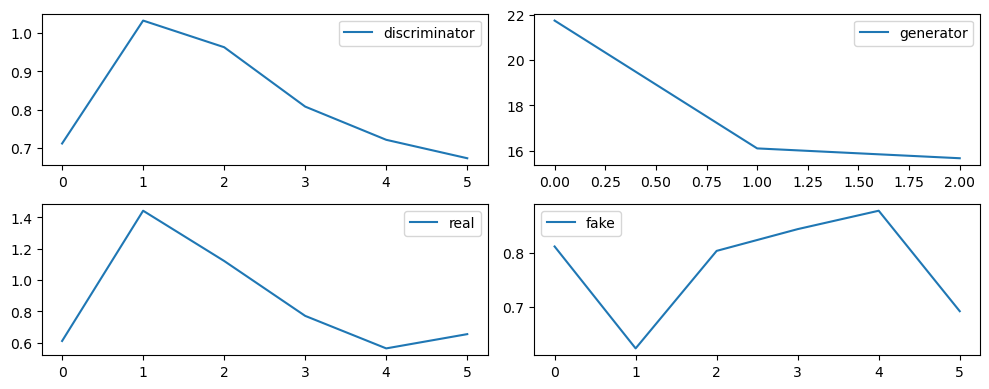

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM: 0.9934
Colourfulness: 0.0276


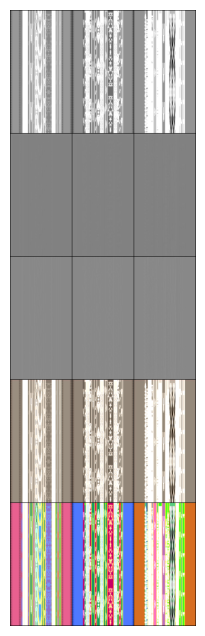

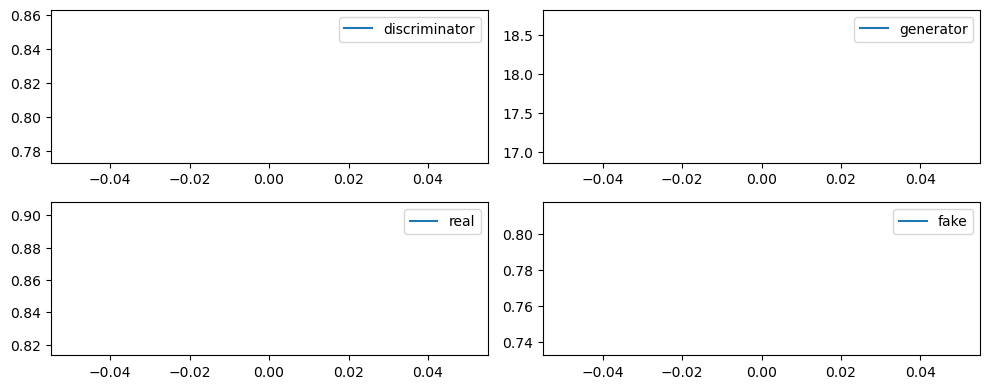

=> Saving checkpoint
EPOCH: 1


  0%|          | 0/6 [00:00<?, ?it/s]

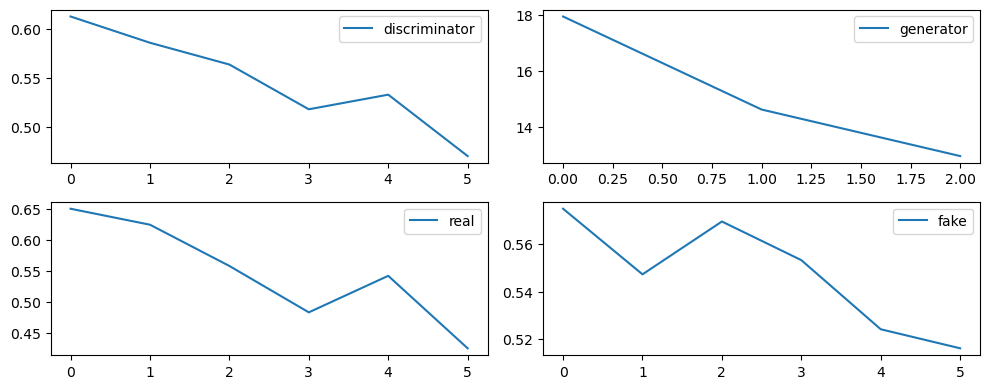

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM: 0.9897
Colourfulness: 0.0237


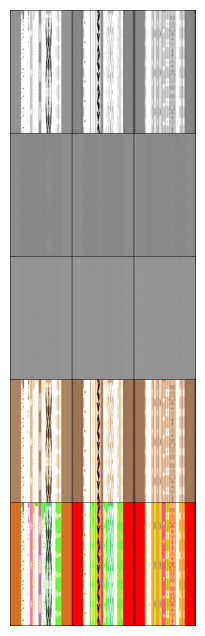

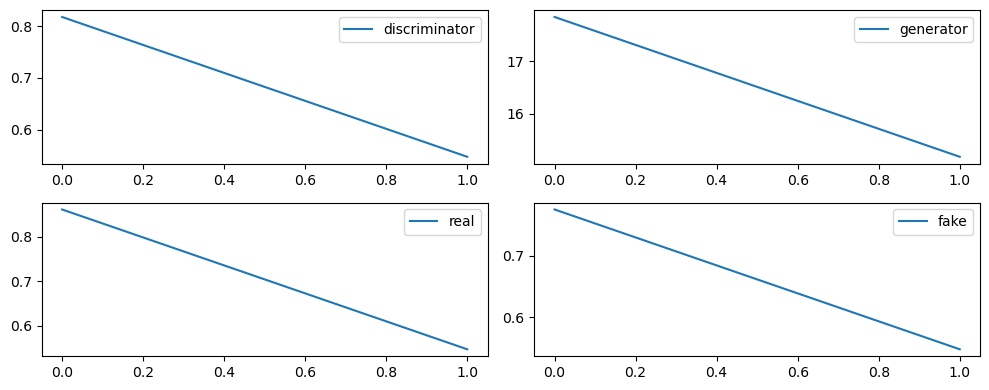

=> Saving checkpoint
EPOCH: 2


  0%|          | 0/6 [00:00<?, ?it/s]

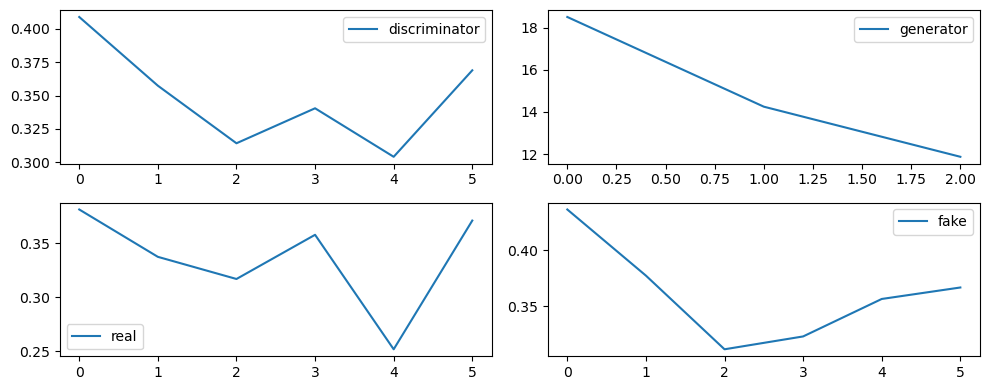

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM: 0.9917
Colourfulness: 0.059


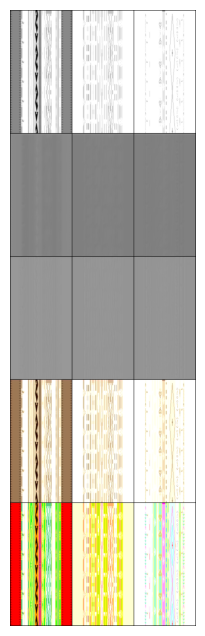

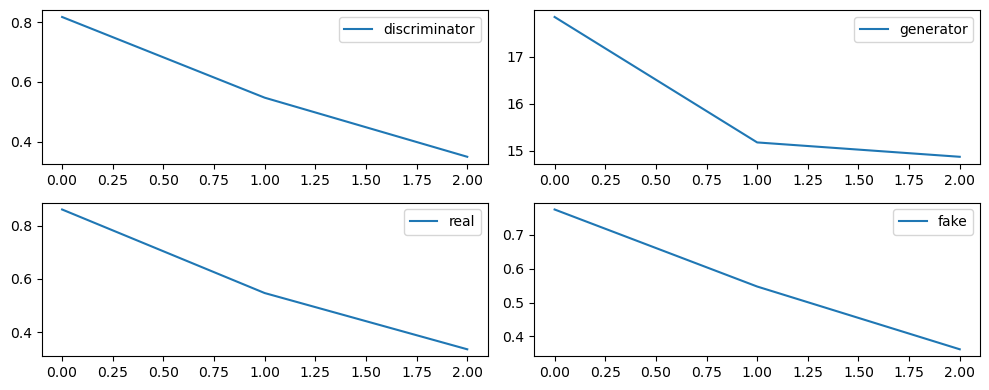

=> Saving checkpoint
EPOCH: 3


  0%|          | 0/6 [00:00<?, ?it/s]

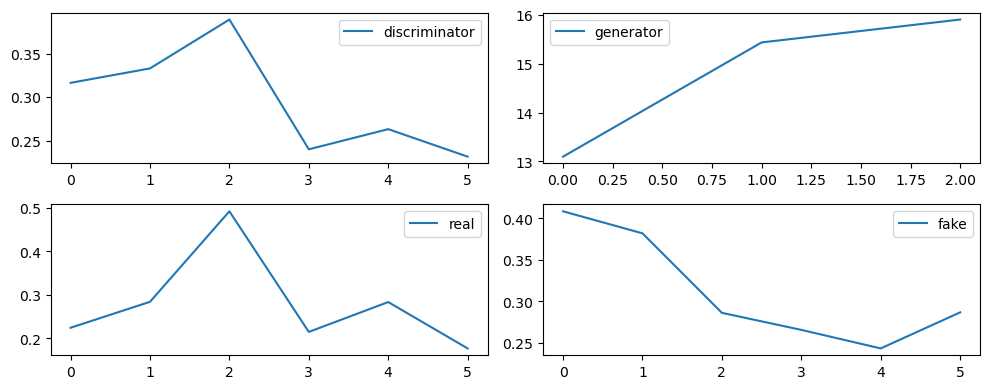

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM: 0.9892
Colourfulness: 0.0344


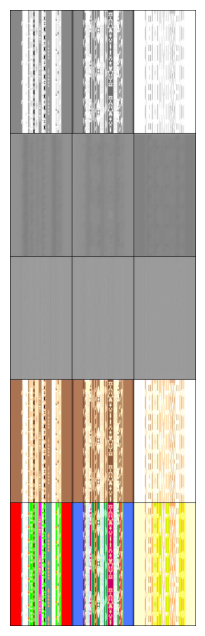

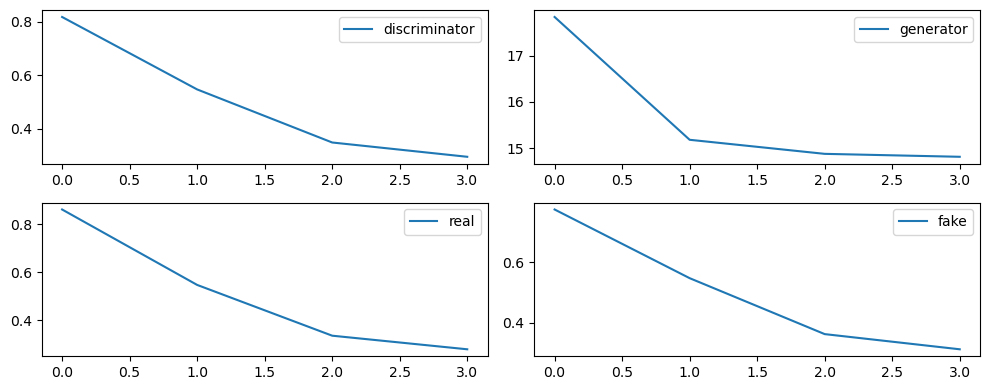

=> Saving checkpoint


In [29]:
# Train the models for 50 epochs
trainer.train(train_dl, epochs=4)

In [30]:
if SaveModel:
    trainer.save_model(epoch)

=> Saving checkpoint


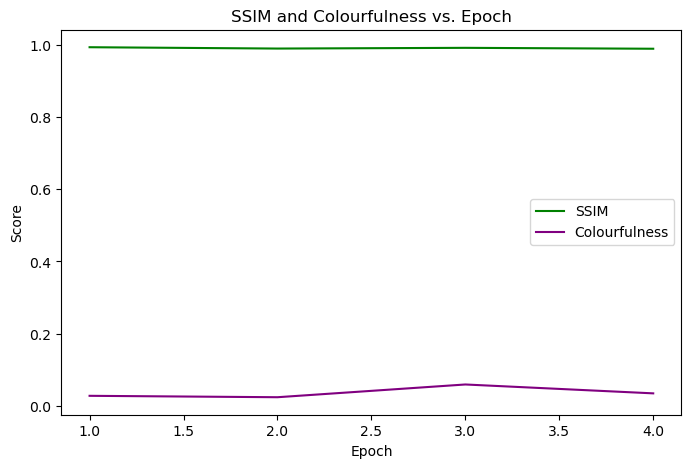

In [31]:
trainer.plot_ssim_and_colourfulness()

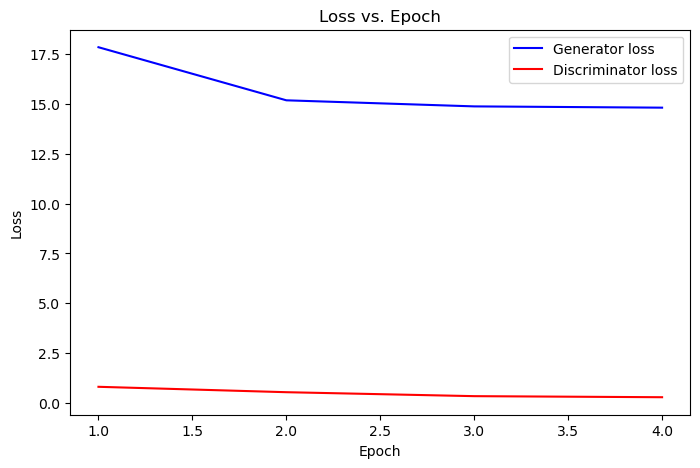

In [32]:
trainer._plot_losses() 	# Plot the generator and discriminator losses per epoch

In [33]:
trainer.G	# Set the generator to evaluation mode

UNet(
  (encoder): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (identity): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (1): EncoderBlock(
      (block): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): ConvBlock(
          (block): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, a